In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/1

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d rasooljader/gestational-diabetes

Dataset URL: https://www.kaggle.com/datasets/rasooljader/gestational-diabetes
License(s): CC-BY-SA-4.0
  0% 0.00/6.30k [00:00<?, ?B/s]
100% 6.30k/6.30k [00:00<00:00, 2.85MB/s]


In [ ]:
!unzip /content/gestational-diabetes.zip

Archive:  /content/gestational-diabetes.zip
  inflating: Gestational Diabetes.csv  


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/Gestational Diabetes.csv',header=None)
# df = pd.read_csv('/content/kddcup.data',header=None)
df.fillna(0, inplace=True)
df.columns = df.iloc[0]
df = df.iloc[1:,:]
df = df.astype(np.float32)

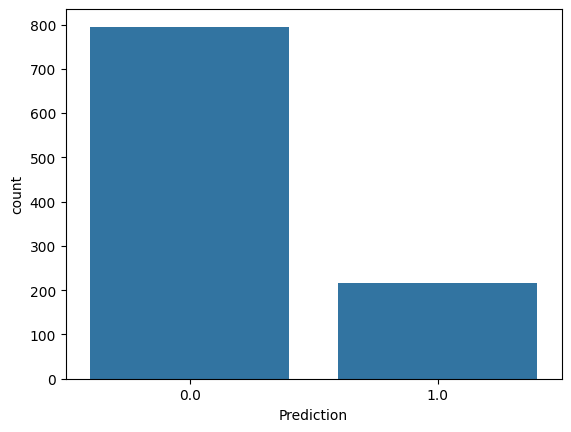

In [ ]:
# prompt: barplot the target

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df.columns[-1], data=df)
plt.show()


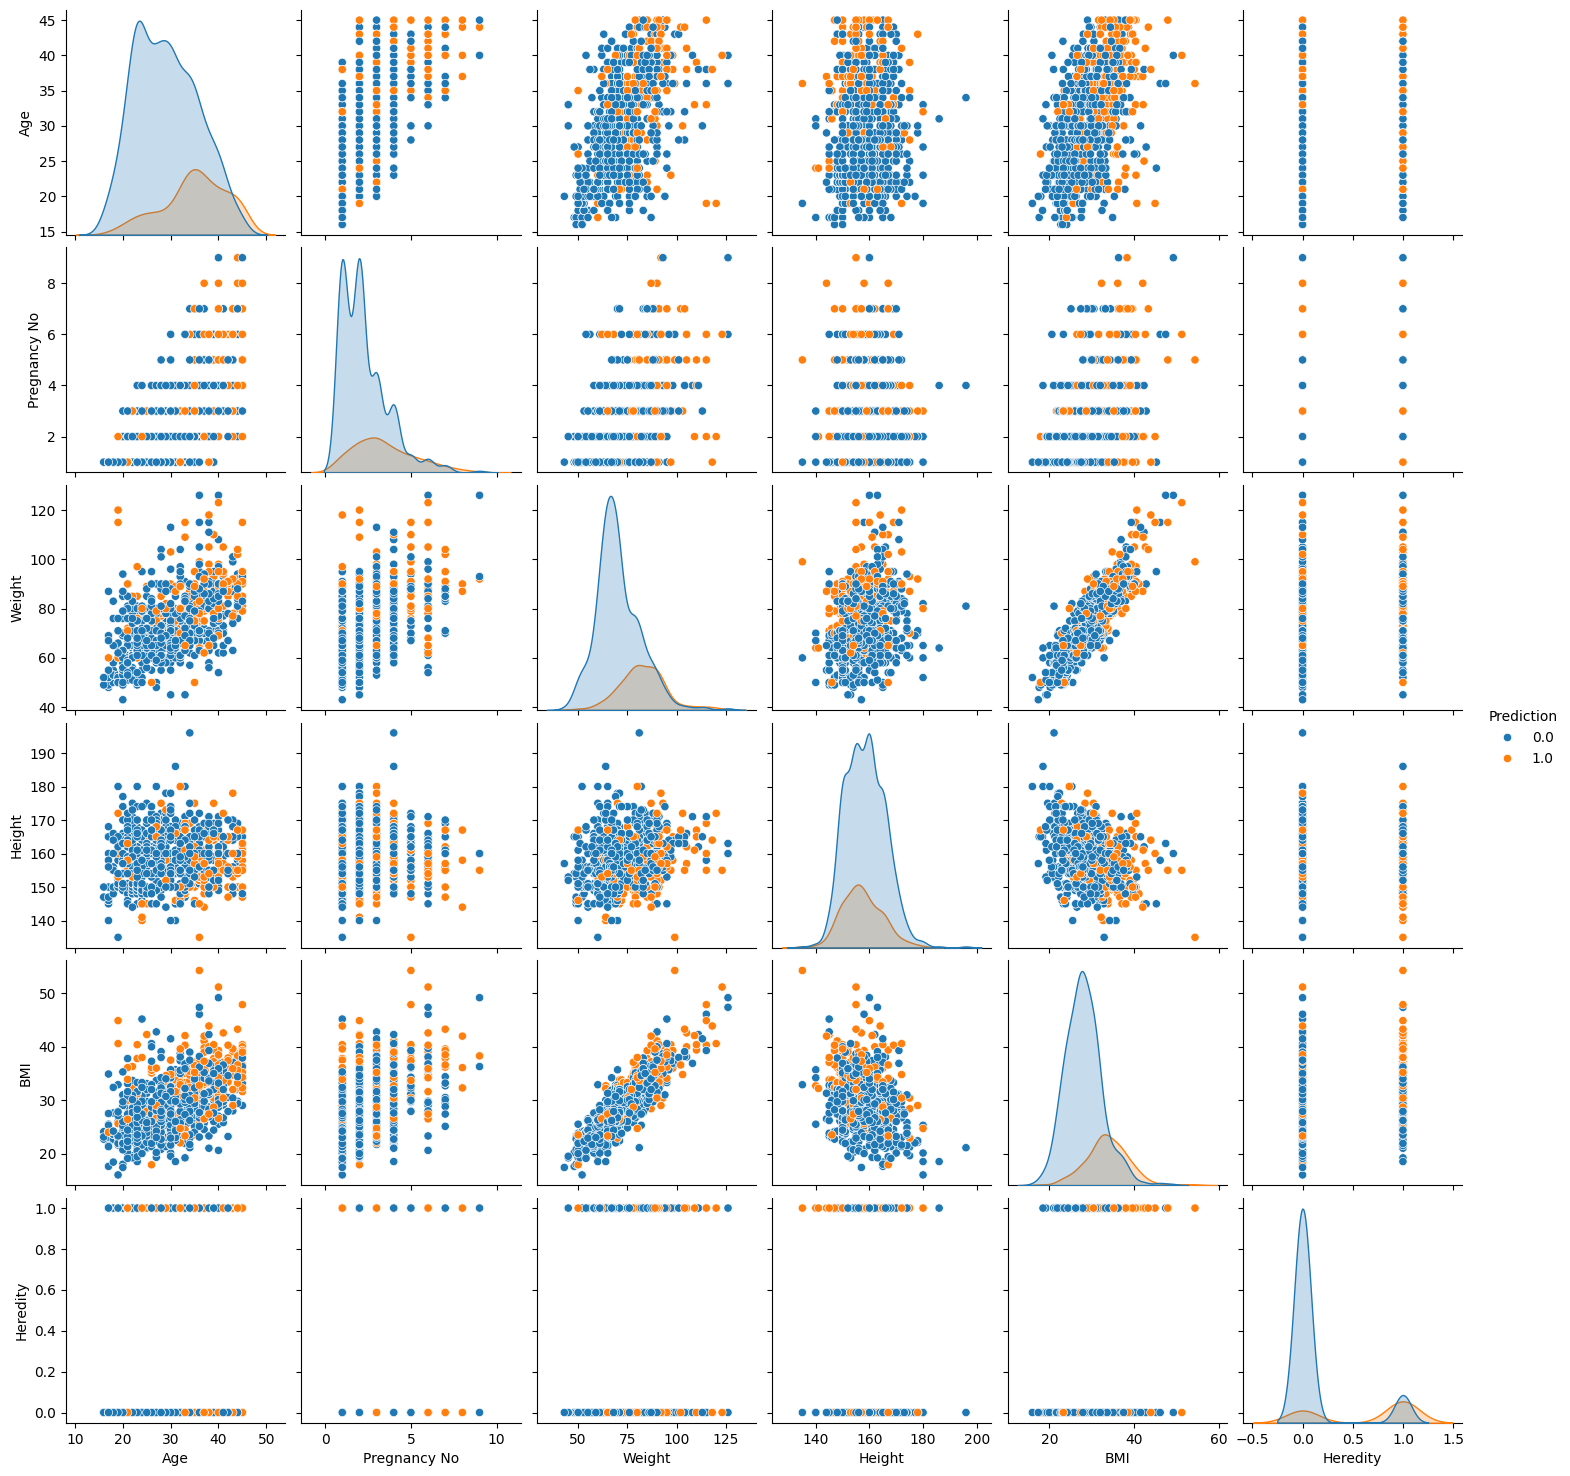

In [ ]:
# prompt: pair plot with the target

sns.pairplot(df, hue=df.columns[-1])
plt.show()


In [ ]:
from collections import OrderedDict
from typing import List, Tuple


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
import pandas as pd
import numpy as np

DEVICE = torch.device("cpu")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

classes = df[df.columns[-1]].unique()

Training on cpu using PyTorch 2.3.1+cu121 and Flower 1.10.0


In [ ]:
#@title Normalize
df = df.astype(np.float16)
df.values[np.isnan(df.values)] = 0
df.iloc[:, 0:-1] = (df.iloc[:, 0:-1] - df.iloc[:, 0:-1].min()) / (df.iloc[:, 0:-1].max() - df.iloc[:, 0:-1].min())
df.values[np.isnan(df.values)] = 0
df


,Age,Pregnancy No,Weight,Height,BMI,Heredity,Prediction
1,0.034485,0.000,0.060242,0.491699,0.041595,0.0,0.0
2,0.034485,0.000,0.072266,0.163940,0.190430,0.0,0.0
3,0.034485,0.000,0.084351,0.081970,0.247925,0.0,0.0
4,0.034485,0.000,0.084351,0.163940,0.203491,0.0,0.0
5,0.034485,0.000,0.072266,0.180298,0.182739,0.0,0.0
...,...,...,...,...,...,...,...
1008,0.655273,0.250,0.554199,0.393555,0.500977,1.0,1.0
1009,0.862305,0.375,0.530273,0.491699,0.417725,0.0,0.0
1010,0.620605,0.125,0.289062,0.409912,0.266357,1.0,0.0
1011,0.586426,0.250,0.265137,0.524414,0.190430,0.0,1.0


In [ ]:
df[np.isnan(df.values)] = 0
np.any(np.isnan(df))

False

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(int).values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 90)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)

# Reshape images back to 3D after oversampling
X_train = X_train_resampled.reshape(-1, 6, 1)
y_train = y_train_resampled

In [ ]:
#@title Normal Partitioner
from flwr_datasets.partitioner import DirichletPartitioner,IidPartitioner
from datasets import Dataset, DatasetDict,concatenate_datasets

NUM_CLIENTS = 3
BATCH_SIZE = 64

def load_datasets():
    # fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    data = {"features": X_train, "labels": y_train}
    dataset_train = Dataset.from_dict(data)

    # partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, partition_by="labels",
    #                                    alpha=0.6, min_partition_size=3,
    #                                   self_balancing=True)
    partitioner =  IidPartitioner(num_partitions=NUM_CLIENTS)
    partitioner.dataset = dataset_train

    data = {"features": X_test, "labels": y_test}
    dataset_test = Dataset.from_dict(data)

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same

        transform = transforms.Compose(
            [
                # transforms.ToTensor(),
                # transforms.Resize(
                #     size=(70, 70)
                # ),

                # transforms.Normalize((0.5), (0.5)),
            ]
        )
        batch["features"] = [transform(np.array(img,dtype=np.float32)) for img in batch["features"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        # partition = partitioner.load_partition(partition_id, "train")
        partition = partitioner.load_partition(partition_id)
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))

        # trainloaders.append(DataLoader(partition, batch_size=BATCH_SIZE))

    # testset = partitioner.load_split("test").with_transform(apply_transforms)
    # testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    dataset_test = dataset_test.with_transform(apply_transforms)
    testloader = DataLoader(dataset_test, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Dirichlet Partitioner
from flwr_datasets.partitioner import DirichletPartitioner
from datasets import Dataset, DatasetDict,concatenate_datasets

NUM_CLIENTS = 3
BATCH_SIZE = 64

def load_datasets():
    # fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    data = {"features": X_train, "labels": y_train}
    dataset_train = Dataset.from_dict(data)

    partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, partition_by="labels",
                                       alpha=0.6, min_partition_size=3,
                                      self_balancing=True)
    partitioner.dataset = dataset_train

    data = {"features": X_test, "labels": y_test}
    dataset_test = Dataset.from_dict(data)

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same

        transform = transforms.Compose(
            [
                # transforms.ToTensor(),
                # transforms.Resize(
                #     size=(70, 70)
                # ),

                # transforms.Normalize((0.5), (0.5)),
            ]
        )
        batch["features"] = [transform(np.array(img,dtype=np.float32)) for img in batch["features"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        # partition = partitioner.load_partition(partition_id, "train")
        partition = partitioner.load_partition(partition_id)
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))

        # trainloaders.append(DataLoader(partition, batch_size=BATCH_SIZE))

    # testset = partitioner.load_split("test").with_transform(apply_transforms)
    # testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    dataset_test = dataset_test.with_transform(apply_transforms)
    testloader = DataLoader(dataset_test, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=11) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 2)
        self.pool = nn.MaxPool1d(2, stride=1)
        # self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 25)
        self.fc3 = nn.Linear(25, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0,2,1)
        # x = self.pool(F.relu(self.conv1(x)))

        # x = torch.flatten(x, start_dim=1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x.squeeze()

In [ ]:
#@title binary
def train(net, trainloader, epochs: int, verbose=True):
    """Train the network on the training set."""
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    # optimizer = torch.optim.SGD(net.parameters(),lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.round(outputs.data) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            loss, accuracy = test(net, testloader)
            print(f"Epoch : {epoch+1} | Train loss : {epoch_loss:.4f} | Train Acc : {epoch_acc:.4f} | Test loss : {loss:.4f} | Test Acc : {accuracy:.4f}")
            # print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            outputs = net(images).squeeze()
            loss += criterion(outputs, labels.float()).item()
            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def get_logits(net, trainloader):
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()
    logits = torch.tensor([]).to(DEVICE)
    with torch.no_grad():
        for batch in trainloader:
            images, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
            outputs = net(images)
            logits = torch.cat([logits,outputs],dim=0)
    return logits

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
        # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
        return [val.cpu().numpy() for name, val in net.state_dict().items() if 'bn' not in name]

def set_parameters(net, parameters: List[np.ndarray]) -> None:
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in net.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=False)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config,
):
    net = Net().to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"###### TEST ###### Server-side evaluation :  loss {loss} | accuracy {accuracy}")
    return loss, {"accuracy TEST": accuracy,"loss TEST":loss}

In [ ]:
global_net = Net().to(DEVICE)
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):
        """Aggregate model weights using weighted average and store checkpoint"""

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            global_net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(global_net.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [ ]:
# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.8,  # Sample 100% of available clients for training
#     fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
#     min_fit_clients=10,  # Never sample less than 10 clients for training
#     min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
#     min_available_clients=10,  # Wait until all 10 clients are available
#     evaluate_metrics_aggregation_fn=weighted_average, # To print the Accuracy after training
#     evaluate_fn=evaluate, # The `evaluate` function will be by Flower called after every round
# )
strategy = SaveModelStrategy(
    fraction_fit=0.8,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=1,  # Never sample less than 10 clients for training
    min_evaluate_clients=1,  # Never sample less than 5 clients for evaluation
    min_available_clients=1,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # To print the Accuracy after training
    evaluate_fn=evaluate, # The `evaluate` function will be by Flower called after every round
)
# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1000),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=500, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-11 21:16:47,747	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3981719961.0, 'memory': 7963439924.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=50528) 2024-08-11 21:16:51.702380: E external/lo

###### TEST ###### Server-side evaluation :  loss 0.014852722583733168 | accuracy 0.22660098522167488
(ClientAppActor pid=50529) [Client 0] get_parameters
(ClientAppActor pid=50529) [Client 1] fit, config: {}
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0128 | Train Acc : 0.0000 | Test loss : 0.0140 | Test Acc : 0.2266


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (1, 0.013970989899095057, {'accuracy TEST': 0.22660098522167488, 'loss TEST': 0.013970989899095057}, 3.8965508669989504)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.013970989899095057 | accuracy 0.22660098522167488
(ClientAppActor pid=50528) [Client 0] evaluate, config: {}


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (2, 0.013232261970125395, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.013232261970125395}, 4.12855628899888)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.013232261970125395 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (3, 0.012630113827183915, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012630113827183915}, 4.373230663999493)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012630113827183915 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (4, 0.0121537720041322, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0121537720041322}, 4.654808866000167)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0121537720041322 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (5, 0.011876305042229262, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011876305042229262}, 4.86186645899943)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011876305042229262 | accuracy 0.7733990147783252


(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=50528)          [repeated 30x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 15x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (6, 0.011677178843268033, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011677178843268033}, 5.082297520999418)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit

Saving round 6 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011677178843268033 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 11x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0103 | Train Acc : 0.6550 | Test loss : 0.0116 | Test Acc : 0.7734 [repeated 11x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (7, 0.011471906612659323, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011471906612659323}, 5.320923915998719)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011471906612659323 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (8, 0.011320789752922621, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011320789752922621}, 5.583207751000373)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011320789752922621 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (9, 0.011283110515237442, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011283110515237442}, 5.84106964700004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011283110515237442 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (10, 0.011201624212593868, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011201624212593868}, 6.064295598000172)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures


Saving round 10 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011201624212593868 | accuracy 0.7733990147783252


INFO :      fit progress: (11, 0.011284687395753532, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011284687395753532}, 6.270383142000355)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011284687395753532 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (12, 0.011262275315270635, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011262275315270635}, 6.54529960400032)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011262275315270635 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (13, 0.011362989841423598, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011362989841423598}, 6.7705199619995255)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011362989841423598 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (14, 0.011394319275917091, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011394319275917091}, 6.982576549999067)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011394319275917091 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (15, 0.011399514422628093, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011399514422628093}, 7.196554918999027)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011399514422628093 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (16, 0.011393748480698159, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011393748480698159}, 7.419021767998856)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011393748480698159 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (17, 0.011383218718279759, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011383218718279759}, 7.792159192000327)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011383218718279759 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (18, 0.011370270563463859, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011370270563463859}, 8.122923076998632)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011370270563463859 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (19, 0.011355869728943398, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011355869728943398}, 8.557649627999126)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011355869728943398 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (20, 0.011340351527547601, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011340351527547601}, 8.986078611000266)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011340351527547601 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 1] evaluate, config: {} [repeated 19x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (21, 0.011323852638892939, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011323852638892939}, 9.449731384998813)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011323852638892939 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (22, 0.011206948404828903, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011206948404828903}, 9.882231269999465)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011206948404828903 | accuracy 0.7733990147783252


(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 51x across cluster]
(ClientAppActor pid=50528)          [repeated 102x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 51x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 51x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (23, 0.01125541549598055, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01125541549598055}, 10.217052878999311)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_f

Saving round 23 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01125541549598055 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 34x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0102 | Train Acc : 0.6550 | Test loss : 0.0113 | Test Acc : 0.7734 [repeated 34x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (24, 0.01111652081823114, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01111652081823114}, 10.631848205999631)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01111652081823114 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (25, 0.011219545685011765, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011219545685011765}, 11.02533184099957)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011219545685011765 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (26, 0.011134417186229687, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011134417186229687}, 11.393911171999207)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 26 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011134417186229687 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (27, 0.011087003012596092, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011087003012596092}, 11.791281371999503)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011087003012596092 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (28, 0.011009290153757104, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011009290153757104}, 12.138756616999672)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011009290153757104 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (29, 0.011007273138450284, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011007273138450284}, 12.596879558999717)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011007273138450284 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (30, 0.011005365496198532, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011005365496198532}, 13.00487999699908)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011005365496198532 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (31, 0.011003563116336691, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011003563116336691}, 13.406996755998989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011003563116336691 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (32, 0.011081185246923288, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011081185246923288}, 13.828199278999818)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011081185246923288 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (33, 0.011057599277919149, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011057599277919149}, 14.165538454999478)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011057599277919149 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 2] evaluate, config: {} [repeated 13x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (34, 0.011043202554063844, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011043202554063844}, 14.42671553999935)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011043202554063844 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (35, 0.011032046649256362, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011032046649256362}, 14.699469739998676)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011032046649256362 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (36, 0.010977074283684416, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010977074283684416}, 14.925560637999297)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010977074283684416 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (37, 0.010976444764677526, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010976444764677526}, 15.164253664999706)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 44x across cluster]
(ClientAppActor pid=50528)          [repeated 88x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 44x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 44x across cluster]
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_

Saving round 37 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010976444764677526 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 1] fit, config: {} [repeated 29x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (38, 0.010975830513855507, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010975830513855507}, 15.406999617998736)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010975830513855507 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0049 | Train Acc : 1.0000 | Test loss : 0.0110 | Test Acc : 0.7734 [repeated 29x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (39, 0.010978787990626444, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010978787990626444}, 15.682497922000039)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010978787990626444 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (40, 0.010978759215970345, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010978759215970345}, 15.93236030799926)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 40 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010978759215970345 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (41, 0.010977574463548332, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010977574463548332}, 16.168732158999774)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 41 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010977574463548332 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (42, 0.010976417751735067, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010976417751735067}, 16.410736808000365)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 42 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010976417751735067 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (43, 0.011025816936211045, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011025816936211045}, 16.67786182599957)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 43 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011025816936211045 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (44, 0.011025753074091644, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011025753074091644}, 16.918581971000094)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 44 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011025753074091644 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (45, 0.011025689505591182, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011025689505591182}, 17.175368256999718)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 45 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011025689505591182 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (46, 0.010974212086259438, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010974212086259438}, 17.404970259000038)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 46 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010974212086259438 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (47, 0.011019689108937832, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011019689108937832}, 17.65265394400012)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 47 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011019689108937832 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (48, 0.011019634936243443, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011019634936243443}, 17.893907902000137)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 48 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011019634936243443 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (49, 0.010972448464097648, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010972448464097648}, 18.14013364799939)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 49 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010972448464097648 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (50, 0.010985609492644887, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010985609492644887}, 18.362336935999338)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 50 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010985609492644887 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (51, 0.010971087687121236, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010971087687121236}, 18.635228903998723)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 51 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010971087687121236 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (52, 0.011008836365685674, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011008836365685674}, 18.85512917199958)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 52 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011008836365685674 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (53, 0.011008795259034105, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011008795259034105}, 19.089888444999815)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures


Saving round 53 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011008795259034105 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Saving round 54 aggregated_parameters...


INFO :      fit progress: (54, 0.01097001436308687, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01097001436308687}, 19.307876322000084)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


###### TEST ###### Server-side evaluation :  loss 0.01097001436308687 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (55, 0.01099268791123564, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01099268791123564}, 19.55635371599965)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 55 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01099268791123564 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (56, 0.010990239863325223, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010990239863325223}, 19.80711914099993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 56 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010990239863325223 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (57, 0.010968320328613808, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010968320328613808}, 20.03255276500022)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 57 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010968320328613808 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (58, 0.010968192897993943, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010968192897993943}, 20.292534504000287)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 62x across cluster]
(ClientAppActor pid=50529)          [repeated 124x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 62x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 62x across cluster]
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure

Saving round 58 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010968192897993943 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 1] fit, config: {} [repeated 40x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0103 | Train Acc : 0.6550 | Test loss : 0.0110 | Test Acc : 0.7734 [repeated 41x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (59, 0.010999776019251405, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010999776019251405}, 20.546606223999333)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 59 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010999776019251405 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (60, 0.011077979808957706, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011077979808957706}, 20.792694802999904)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 60 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011077979808957706 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (61, 0.010995104101491092, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010995104101491092}, 21.016248141999313)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 61 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010995104101491092 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (62, 0.011069592877561823, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011069592877561823}, 21.23509454499981)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 62 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011069592877561823 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (63, 0.010990780709412298, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010990780709412298}, 21.483560712000326)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 63 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010990780709412298 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (64, 0.011061516448194758, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011061516448194758}, 21.72737534099906)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 64 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011061516448194758 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (65, 0.010986806723871841, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010986806723871841}, 21.961993941999026)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 65 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010986806723871841 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (66, 0.010986786757783936, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010986786757783936}, 22.218806164999478)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 66 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010986786757783936 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (67, 0.010986767672552852, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010986767672552852}, 22.459286576999148)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 67 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010986767672552852 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (68, 0.010968620847598672, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010968620847598672}, 22.708361998000328)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 68 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010968620847598672 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (69, 0.011014339371855036, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011014339371855036}, 22.92328503799945)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 69 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011014339371855036 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (70, 0.010969214545094908, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010969214545094908}, 23.146027474998846)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 70 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010969214545094908 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (71, 0.01101927730837479, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01101927730837479}, 23.378429226999287)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 71 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01101927730837479 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (72, 0.011126038035735707, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011126038035735707}, 23.6451691989987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 72 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011126038035735707 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (73, 0.011173494050068221, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011173494050068221}, 23.8695363679999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 73 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011173494050068221 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (74, 0.011069108406311185, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011069108406311185}, 24.1468643850003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 74 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011069108406311185 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 2] evaluate, config: {} [repeated 21x across cluster]

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (75, 0.011128379353161516, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011128379353161516}, 24.49835795599938)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)



Saving round 75 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011128379353161516 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (76, 0.010987686846643833, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010987686846643833}, 24.866144740999516)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 76 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010987686846643833 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (77, 0.010967748505728585, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010967748505728585}, 25.245460255999205)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 58x across cluster]
(ClientAppActor pid=50529)          [repeated 116x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 58x across cluster]
(ClientAppActor pid=50529)             entirely in future versio

Saving round 77 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010967748505728585 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 39x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (78, 0.010907431541405287, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010907431541405287}, 25.637450330999854)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0101 | Train Acc : 0.6550 | Test loss : 0.0111 | Test Acc : 0.7734 [repeated 38x across cluster]
Saving round 78 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010907431541405287 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (79, 0.010906668425780799, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010906668425780799}, 26.013273131999085)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 79 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010906668425780799 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (80, 0.010971619577830648, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010971619577830648}, 26.401503526998567)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 80 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010971619577830648 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (81, 0.010907781681990976, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010907781681990976}, 26.76384932399924)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 81 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010907781681990976 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (82, 0.010907444607448108, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010907444607448108}, 27.121333700999458)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 82 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010907444607448108 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (83, 0.010962970444721542, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010962970444721542}, 27.46559594700011)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 83 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010962970444721542 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (84, 0.011066899217408279, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011066899217408279}, 27.8349637299998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 84 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011066899217408279 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (85, 0.01106667107549207, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01106667107549207}, 28.228792758000054)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 85 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01106667107549207 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (86, 0.01106644352081374, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01106644352081374}, 28.676361096999244)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 86 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01106644352081374 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (87, 0.0109557574018469, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0109557574018469}, 29.053294498999094)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 87 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0109557574018469 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (88, 0.011055723052893953, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011055723052893953}, 29.44389439599945)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) [Client 2] evaluate, config: {} [repeated 13x across cluster]
Saving round 88 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011055723052893953 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (89, 0.011055510179162613, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011055510179162613}, 29.887967597998795)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 89 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011055510179162613 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (90, 0.011197400944573539, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011197400944573539}, 30.207596639000258)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 90 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011197400944573539 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 41x across cluster]
(ClientAppActor pid=50529)          [repeated 82x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 41x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 41x across cluster]
INFO :      fit progress: (91, 0.01137466603899237, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01137466603899237}, 30.45240225299858)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit

Saving round 91 aggregated_parameters...
(ClientAppActor pid=50528) [Client 2] fit, config: {} [repeated 27x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.01137466603899237 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (92, 0.011183367574156212, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011183367574156212}, 30.71904229899883)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0033 | Train Acc : 1.0000 | Test loss : 0.0114 | Test Acc : 0.7734 [repeated 28x across cluster]
Saving round 92 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011183367574156212 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (93, 0.011034664702532913, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011034664702532913}, 30.942225400000098)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 93 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011034664702532913 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (94, 0.0110344819247429, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0110344819247429}, 31.193830489999527)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 94 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0110344819247429 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (95, 0.010936944795946769, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010936944795946769}, 31.42736935100038)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 95 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010936944795946769 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (96, 0.010936905010580429, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010936905010580429}, 31.73812361399905)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 96 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010936905010580429 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (97, 0.010899466540425869, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010899466540425869}, 31.96334585600016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 97 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010899466540425869 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (98, 0.01089929095629988, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01089929095629988}, 32.207274592999966)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 98 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01089929095629988 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (99, 0.010899117427506471, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010899117427506471}, 32.46431018200019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 99 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010899117427506471 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (100, 0.010932042974556608, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010932042974556608}, 32.74736454699996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 100 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010932042974556608 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (101, 0.01101664692310277, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01101664692310277}, 32.96153941800003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 101 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01101664692310277 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (102, 0.011145640182964907, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011145640182964907}, 33.189160027999606)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 102 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011145640182964907 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (103, 0.011312189947795398, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011312189947795398}, 33.41949161699995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 104]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 103 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011312189947795398 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (104, 0.011132680430200886, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011132680430200886}, 33.692749869998806)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 105]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 104 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011132680430200886 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (105, 0.010998360775961665, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010998360775961665}, 33.911409456999536)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 106]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 105 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010998360775961665 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (106, 0.010918000795571087, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010918000795571087}, 34.156632812999305)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 107]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 106 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010918000795571087 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (107, 0.010989933471961562, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010989933471961562}, 34.385862917999475)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 108]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 107 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010989933471961562 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 1] evaluate, config: {} [repeated 20x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (108, 0.011108140786880343, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011108140786880343}, 34.64263824099908)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 109]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 108 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011108140786880343 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (109, 0.011107858178650804, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011107858178650804}, 34.910834663998685)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 110]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 109 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011107858178650804 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (110, 0.010981480623113698, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010981480623113698}, 35.132675482000195)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 110 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010981480623113698 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (111, 0.011095936662457846, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011095936662457846}, 35.35361934699904)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 62x across cluster]
(ClientAppActor pid=50529)          [repeated 124x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 62x across cluster]
(ClientAppActor pid=50529)             entirely in future versi

Saving round 111 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011095936662457846 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 42x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (112, 0.011095667707509008, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011095667707509008}, 35.654807450999215)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 112 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011095667707509008 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0108 | Train Acc : 0.6550 | Test loss : 0.0110 | Test Acc : 0.7734 [repeated 42x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (113, 0.010973404780984512, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010973404780984512}, 35.89694266799961)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 113 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010973404780984512 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (114, 0.010973312437827952, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010973312437827952}, 36.14491264299977)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 114 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010973312437827952 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (115, 0.010907251406185732, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010907251406185732}, 36.37099957999999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 115 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010907251406185732 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (116, 0.010965968881334578, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010965968881334578}, 36.63515978099895)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 116 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010965968881334578 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (117, 0.010965887548888258, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010965887548888258}, 36.902270806998786)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 117 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010965887548888258 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (118, 0.010965805922822999, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010965805922822999}, 37.14064755799882)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 118 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010965805922822999 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (119, 0.01096572414994827, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01096572414994827}, 37.3815507829986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 119 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01096572414994827 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (120, 0.01107275030883075, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01107275030883075}, 37.65115440499903)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures


Saving round 120 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01107275030883075 | accuracy 0.7733990147783252


INFO :      fit progress: (121, 0.010958573794717272, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010958573794717272}, 37.87227478599925)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 121 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010958573794717272 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (122, 0.010902117332214205, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010902117332214205}, 38.11802881599942)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 122 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010902117332214205 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (123, 0.010902054497761092, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010902054497761092}, 38.36293193900019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 123 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010902054497761092 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (124, 0.0109019925441648, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0109019925441648}, 38.64950510899871)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 124 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0109019925441648 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (125, 0.010901931618234793, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010901931618234793}, 38.89026428800025)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 126]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 125 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010901931618234793 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (126, 0.01090187039868585, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01090187039868585}, 39.16069652799888)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 127]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 126 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01090187039868585 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (127, 0.010911161676416255, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010911161676416255}, 39.38787145999959)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 128]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 127 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010911161676416255 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] evaluate, config: {} [repeated 20x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (128, 0.010992280955385104, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010992280955385104}, 39.65536473300017)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 129]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 128 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010992280955385104 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (129, 0.010912017575625715, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010912017575625715}, 39.91893782899933)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 130]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 129 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010912017575625715 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (130, 0.010910063247962539, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010910063247962539}, 40.29359297999872)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 131]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 130 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010910063247962539 | accuracy 0.7733990147783252


(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 58x across cluster]
(ClientAppActor pid=50528)          [repeated 116x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 58x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 58x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (131, 0.010908238993489684, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010908238993489684}, 40.698925482998675)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 132]
INFO :      configu

(ClientAppActor pid=50528) [Client 0] fit, config: {} [repeated 39x across cluster]
Saving round 131 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010908238993489684 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0050 | Train Acc : 1.0000 | Test loss : 0.0109 | Test Acc : 0.7734 [repeated 38x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (132, 0.010906541876017754, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010906541876017754}, 41.1276689919996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 133]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 132 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010906541876017754 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (133, 0.010904934899560336, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010904934899560336}, 41.52816020499995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 134]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 133 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010904934899560336 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (134, 0.01089573743308119, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01089573743308119}, 41.86496381699908)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 135]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 134 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01089573743308119 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (135, 0.010944231683984765, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010944231683984765}, 42.22904149699934)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 136]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 135 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010944231683984765 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (136, 0.010894058666792996, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010894058666792996}, 42.623328923999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 137]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 136 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010894058666792996 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (137, 0.010893963974684917, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010893963974684917}, 43.01480099299988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 138]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 137 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010893963974684917 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (138, 0.010911483189155316, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010911483189155316}, 43.38527222799894)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 139]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 138 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010911483189155316 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (139, 0.011000358706037399, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011000358706037399}, 43.772468897999715)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 140]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 139 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011000358706037399 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (140, 0.01095792019895732, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01095792019895732}, 44.15500421999968)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 141]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 140 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01095792019895732 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (141, 0.010936037660232318, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010936037660232318}, 44.621743931998935)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 142]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 141 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010936037660232318 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 2] evaluate, config: {} [repeated 13x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (142, 0.01092278032467283, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01092278032467283}, 45.01227803300026)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 143]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 142 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01092278032467283 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (143, 0.01086996165402417, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01086996165402417}, 45.400277187998654)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 144]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 143 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01086996165402417 | accuracy 0.7733990147783252


(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 38x across cluster]
(ClientAppActor pid=50529)          [repeated 76x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 38x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 38x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (144, 0.010928235177336067, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010928235177336067}, 45.80193971500012)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 145]
INFO :      configure

(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 25x across cluster]
Saving round 144 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010928235177336067 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0101 | Train Acc : 0.6550 | Test loss : 0.0109 | Test Acc : 0.7734 [repeated 26x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (145, 0.01087076616991917, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01087076616991917}, 46.15759694400003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 146]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 145 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01087076616991917 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (146, 0.010870101269830037, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010870101269830037}, 46.46967144500013)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 147]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 146 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010870101269830037 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (147, 0.010932336006258508, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010932336006258508}, 46.740230777999386)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 148]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 147 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010932336006258508 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (148, 0.010871040116389985, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010871040116389985}, 46.974224375999256)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 149]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 148 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010871040116389985 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (149, 0.010875747121613601, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010875747121613601}, 47.20269845599978)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 150]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 149 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010875747121613601 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (150, 0.010938259474749636, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010938259474749636}, 47.46207318300003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 150 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010938259474749636 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (151, 0.010872892411471588, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010872892411471588}, 47.73390840899992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 151 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010872892411471588 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (152, 0.010930857634896715, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010930857634896715}, 47.94868651300021)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 152 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010930857634896715 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (153, 0.011039336620293227, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011039336620293227}, 48.19105482499981)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 154]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 153 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011039336620293227 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (154, 0.011039095705953138, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011039095705953138}, 48.47558099299931)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 155]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 154 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011039095705953138 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (155, 0.011038856259707746, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011038856259707746}, 48.76486541899976)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 156]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 155 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011038856259707746 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (156, 0.010923318968617857, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010923318968617857}, 49.008088454000244)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 157]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 156 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010923318968617857 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (157, 0.010923249821357539, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010923249821357539}, 49.25841536999906)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 158]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 157 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010923249821357539 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (158, 0.01092318096771616, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01092318096771616}, 49.54771562499991)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 159]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 158 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01092318096771616 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] evaluate, config: {} [repeated 18x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (159, 0.011027581879658065, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011027581879658065}, 49.786687552999865)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 160]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 159 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011027581879658065 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (160, 0.011175624108666857, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011175624108666857}, 50.01433130700025)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 161]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 160 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011175624108666857 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (161, 0.011016555607612498, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011016555607612498}, 50.244883862998904)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 162]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 161 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011016555607612498 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (162, 0.010909920842776744, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010909920842776744}, 50.48944904199925)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 163]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 162 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010909920842776744 | accuracy 0.7733990147783252


(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 57x across cluster]
(ClientAppActor pid=50529)          [repeated 114x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 57x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 57x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (163, 0.011006036562285399, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011006036562285399}, 50.776539442000285)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 164]
INFO :      configu

(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 38x across cluster]
Saving round 163 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011006036562285399 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (164, 0.011147101083999784, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011147101083999784}, 51.002520893998735)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 165]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0041 | Train Acc : 1.0000 | Test loss : 0.0110 | Test Acc : 0.7734 [repeated 38x across cluster]
Saving round 164 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011147101083999784 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (165, 0.010995697505368388, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010995697505368388}, 51.251591696000105)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 166]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 165 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010995697505368388 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (166, 0.010995515168006785, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010995515168006785}, 51.51904152199859)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 167]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 166 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010995515168006785 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (167, 0.01099533356469253, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01099533356469253}, 51.79401384999983)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 168]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 167 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01099533356469253 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (168, 0.01089795645821858, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01089795645821858}, 52.02691118399889)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 169]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 168 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01089795645821858 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (169, 0.010864261042308337, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010864261042308337}, 52.25878330500018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 170]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 169 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010864261042308337 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (170, 0.010892902395408141, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010892902395408141}, 52.58873198499896)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Saving round 170 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010892902395408141 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 171]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (171, 0.010892872739895225, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010892872739895225}, 53.17638483900009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures


Saving round 171 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010892872739895225 | accuracy 0.7733990147783252


INFO :      
INFO :      [ROUND 172]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (172, 0.010976391032411548, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010976391032411548}, 53.51650756399977)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 173]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 172 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010976391032411548 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (173, 0.010976235854801872, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010976235854801872}, 53.775120495998635)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 174]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 173 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010976235854801872 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (174, 0.01097608008995432, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01097608008995432}, 54.03636025000014)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 175]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 174 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01097608008995432 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (175, 0.010887817208990088, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010887817208990088}, 54.27587270899858)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 176]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 175 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010887817208990088 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (176, 0.010864809669297317, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010864809669297317}, 54.529046046000076)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 177]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 176 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010864809669297317 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 1] evaluate, config: {} [repeated 18x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (177, 0.010915757400061697, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010915757400061697}, 54.801887171999624)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 178]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 177 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010915757400061697 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (178, 0.010906393892072104, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010906393892072104}, 55.05312438100009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 179]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 178 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010906393892072104 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (179, 0.01086078356639505, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01086078356639505}, 55.28234005000013)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 180]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 179 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01086078356639505 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (180, 0.010860378665877093, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010860378665877093}, 55.580530000999715)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 181]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 54x across cluster]
(ClientAppActor pid=50529)          [repeated 108x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 54x across cluster]
(ClientAppActor pid=50529)             entirely in future vers

Saving round 180 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010860378665877093 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 36x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (181, 0.010910661496552341, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010910661496552341}, 55.829375470999366)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 182]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 181 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010910661496552341 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0411 | Train Acc : 0.1429 | Test loss : 0.0109 | Test Acc : 0.7734 [repeated 36x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (182, 0.010860814249574257, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010860814249574257}, 56.08311892100028)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 183]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 182 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010860814249574257 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (183, 0.010916071572327261, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010916071572327261}, 56.322087870999894)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 184]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 183 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010916071572327261 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (184, 0.011030444223892513, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011030444223892513}, 56.725577840999904)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 185]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 184 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011030444223892513 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (185, 0.010945859947815318, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010945859947815318}, 57.105243521000375)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 186]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 185 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010945859947815318 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (186, 0.011020526510154085, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011020526510154085}, 57.455744229999254)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 187]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 186 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011020526510154085 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (187, 0.010916148206870544, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010916148206870544}, 57.86169116699966)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 188]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 187 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010916148206870544 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (188, 0.010818180045470815, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010818180045470815}, 58.289185384999655)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 189]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 188 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010818180045470815 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (189, 0.010814723122883313, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010814723122883313}, 58.721679581998615)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 190]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 189 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010814723122883313 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (190, 0.010795091760569605, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010795091760569605}, 59.10180816399952)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 191]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 190 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010795091760569605 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (191, 0.010794954053286848, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010794954053286848}, 59.51698166099959)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 192]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 191 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010794954053286848 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (192, 0.010818269452437978, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010818269452437978}, 59.89369080199867)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 193]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Saving round 192 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010818269452437978 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (193, 0.010920373089795042, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010920373089795042}, 60.31684439899982)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 194]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 193 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010920373089795042 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (194, 0.010816927467073714, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010816927467073714}, 60.70806121500027)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 41x across cluster]
(ClientAppActor pid=50528)          [repeated 82x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 41x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 41x across cluster]
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 195]
INFO :      configure

Saving round 194 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010816927467073714 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 27x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (195, 0.010812779659120907, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010812779659120907}, 61.1630993079998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0362 | Train Acc : 0.1429 | Test loss : 0.0110 | Test Acc : 0.7734 [repeated 26x across cluster]
Saving round 195 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010812779659120907 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 196]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (196, 0.010914360361146222, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010914360361146222}, 61.56745409999894)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 197]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 196 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010914360361146222 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (197, 0.0109729123820225, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0109729123820225}, 61.93482665099873)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 198]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 197 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0109729123820225 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (198, 0.010970543317606885, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010970543317606885}, 62.35707044799892)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 199]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 198 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010970543317606885 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (199, 0.01080590692059747, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01080590692059747}, 62.763091262999296)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 200]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 199 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01080590692059747 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (200, 0.010730372420672712, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010730372420672712}, 62.97769735200018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 201]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 200 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010730372420672712 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (201, 0.010811514161490454, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010811514161490454}, 63.214912665000156)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 202]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 201 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010811514161490454 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (202, 0.01073115007043472, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01073115007043472}, 63.47839922099956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 203]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 202 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01073115007043472 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (203, 0.010730649890570805, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010730649890570805}, 63.75124777699966)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 204]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 203 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010730649890570805 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (204, 0.010730583092262005, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010730583092262005}, 64.00920374999987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 205]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 204 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010730583092262005 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (205, 0.010799919883605881, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010799919883605881}, 64.24803483999858)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 206]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 205 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010799919883605881 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (206, 0.010928704233592367, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010928704233592367}, 64.52277074300036)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 207]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 206 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010928704233592367 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (207, 0.010928390501755212, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010928390501755212}, 64.80792314899918)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 208]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 207 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010928390501755212 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] evaluate, config: {} [repeated 16x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (208, 0.011106931810895797, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011106931810895797}, 65.03483534499901)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 209]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 208 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011106931810895797 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (209, 0.011106411811753448, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011106411811753448}, 65.30107852199944)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 210]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 209 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011106411811753448 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (210, 0.011325897841617978, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011325897841617978}, 65.5839250099998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 211]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 210 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011325897841617978 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 50x across cluster]
(ClientAppActor pid=50528)          [repeated 100x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 50x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 50x across cluster]
INFO :      fit progress: (211, 0.011325198147684483, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011325198147684483}, 65.85761078399992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 212]
INFO :      configur

Saving round 211 aggregated_parameters...
(ClientAppActor pid=50528) [Client 1] fit, config: {} [repeated 34x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.011325198147684483 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (212, 0.011324498453750987, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011324498453750987}, 66.1131230359988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 213]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0113 | Train Acc : 0.6550 | Test loss : 0.0111 | Test Acc : 0.7734 [repeated 35x across cluster]
Saving round 212 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011324498453750987 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (213, 0.011087538133113842, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011087538133113842}, 66.33783882999887)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 214]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 213 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011087538133113842 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (214, 0.010900235968857563, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010900235968857563}, 66.62046726399967)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 215]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 214 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010900235968857563 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (215, 0.010899963196862508, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010899963196862508}, 66.87444158499966)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 216]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 215 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010899963196862508 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (216, 0.010899689837629572, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010899689837629572}, 67.12833148800019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 217]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 216 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010899689837629572 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (217, 0.011069821606715912, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011069821606715912}, 67.37950694899882)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 218]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 217 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011069821606715912 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (218, 0.010887060699791744, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010887060699791744}, 67.6700111329992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 219]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 218 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010887060699791744 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (219, 0.010886807013027773, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010886807013027773}, 67.92886520599859)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 220]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 219 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010886807013027773 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (220, 0.010766262050919932, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010766262050919932}, 68.14461857899914)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 221]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 220 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010766262050919932 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (221, 0.010720204103169182, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010720204103169182}, 68.39011202499933)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 222]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 221 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010720204103169182 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (222, 0.0107199134204188, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0107199134204188}, 68.70185917500021)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 223]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 222 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0107199134204188 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (223, 0.010759192000468964, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010759192000468964}, 68.96251965599913)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 224]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 223 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010759192000468964 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (224, 0.010719236922381546, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010719236922381546}, 69.19013489499957)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 225]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 224 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010719236922381546 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (225, 0.010718882671130702, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010718882671130702}, 69.44597603299917)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 226]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 225 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010718882671130702 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (226, 0.01076353756077771, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01076353756077771}, 69.73892021199936)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 227]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 226 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01076353756077771 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (227, 0.010718494653701782, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010718494653701782}, 69.97849123000015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 228]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 227 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010718494653701782 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] evaluate, config: {} [repeated 19x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (228, 0.010749324495569238, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010749324495569238}, 70.27725691699925)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 229]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 228 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010749324495569238 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (229, 0.01071895372691413, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01071895372691413}, 70.56410582399985)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 230]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 229 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01071895372691413 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (230, 0.010744009699140276, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010744009699140276}, 70.81046007499936)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 231]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 58x across cluster]
(ClientAppActor pid=50529)          [repeated 116x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 58x across cluster]
(ClientAppActor pid=50529)             entirely in future versi

Saving round 230 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010744009699140276 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 38x across cluster]
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0042 | Train Acc : 1.0000 | Test loss : 0.0109 | Test Acc : 0.7734 [repeated 38x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (231, 0.010835439407179508, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010835439407179508}, 71.39656148299946)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 232]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 231 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010835439407179508 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (232, 0.01073902126016288, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01073902126016288}, 71.6950063739987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 233]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 232 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01073902126016288 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (233, 0.010825209282889155, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010825209282889155}, 71.92551909800022)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 234]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 233 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010825209282889155 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (234, 0.010734528303146362, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010734528303146362}, 72.15967345599893)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 235]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 234 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010734528303146362 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (235, 0.010734486168828505, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010734486168828505}, 72.42439916900003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 236]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 235 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010734486168828505 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (236, 0.010734443300463296, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010734443300463296}, 73.20816838399878)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 237]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 236 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010734443300463296 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (237, 0.010723204595114798, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010723204595114798}, 73.5601541899996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 238]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 237 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010723204595114798 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (238, 0.010722053021632979, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010722053021632979}, 73.93974847800018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 239]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 238 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010722053021632979 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (239, 0.01073048252777513, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01073048252777513}, 74.31419001699942)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 240]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 239 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01073048252777513 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (240, 0.010807777860481751, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010807777860481751}, 74.72937646900027)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 241]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 240 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010807777860481751 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (241, 0.010726826091118047, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010726826091118047}, 75.10017693099871)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 242]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) [Client 0] evaluate, config: {} [repeated 14x across cluster]
Saving round 241 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010726826091118047 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (242, 0.010727448710079851, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010727448710079851}, 75.50899027599917)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 243]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 242 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010727448710079851 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (243, 0.010816767297942063, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010816767297942063}, 75.93622098800006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 244]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 39x across cluster]
(ClientAppActor pid=50528)          [repeated 78x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 39x across cluster]
(ClientAppActor pid=50528)             entirely in future versio

Saving round 243 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010816767297942063 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 0] fit, config: {} [repeated 26x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (244, 0.010767214844379518, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010767214844379518}, 76.33330763699996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0395 | Train Acc : 0.1429 | Test loss : 0.0107 | Test Acc : 0.7734 [repeated 25x across cluster]
Saving round 244 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010767214844379518 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 245]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (245, 0.010702380405858232, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010702380405858232}, 76.71910899199975)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 246]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 245 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010702380405858232 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (246, 0.010773183089758963, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010773183089758963}, 77.12603524199949)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 247]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 246 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010773183089758963 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (247, 0.01074071764358746, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01074071764358746}, 77.62106456699985)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Saving round 247 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01074071764358746 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 248]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (248, 0.01085418374667614, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01085418374667614}, 78.69740441199974)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 249]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 248 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01085418374667614 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (249, 0.010870870257833322, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010870870257833322}, 78.92987208900013)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 250]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 249 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010870870257833322 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (250, 0.010732511141030071, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010732511141030071}, 79.20358420899902)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 251]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 250 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010732511141030071 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (251, 0.010788153838641538, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010788153838641538}, 79.45640153699969)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 252]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 251 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010788153838641538 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (252, 0.010631856072712415, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010631856072712415}, 79.72481226799937)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 253]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 252 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010631856072712415 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (253, 0.01057636018457084, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01057636018457084}, 79.9615604369992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 254]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 253 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01057636018457084 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 1] evaluate, config: {} [repeated 13x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (254, 0.01060989528453996, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01060989528453996}, 80.22306071799903)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 255]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 254 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01060989528453996 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (255, 0.010577070742405107, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010577070742405107}, 80.48500697999953)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 256]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 255 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010577070742405107 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (256, 0.0105762384795203, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0105762384795203}, 80.79395154099984)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 257]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 256 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0105762384795203 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (257, 0.010604155621505136, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010604155621505136}, 81.01886994799861)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 41x across cluster]
(ClientAppActor pid=50528)          [repeated 82x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 41x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 41x across cluster]
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 258]
INFO :      configure

Saving round 257 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010604155621505136 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 2] fit, config: {} [repeated 28x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (258, 0.01057741457018359, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01057741457018359}, 81.28563975399993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 259]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 258 aggregated_parameters...
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0101 | Train Acc : 0.6550 | Test loss : 0.0106 | Test Acc : 0.7734 [repeated 29x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.01057741457018359 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (259, 0.010653335032204688, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010653335032204688}, 81.57311193999885)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 260]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 259 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010653335032204688 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (260, 0.010740832008164504, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010740832008164504}, 81.81780536099905)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 261]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 260 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010740832008164504 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (261, 0.010592811360147785, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010592811360147785}, 82.06121028399866)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 262]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 261 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010592811360147785 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (262, 0.010575368486601731, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010575368486601731}, 82.34505995499967)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 263]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 262 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010575368486601731 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (263, 0.010696927021289694, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010696927021289694}, 82.65885304400035)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 264]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 263 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010696927021289694 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (264, 0.010563376208244286, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010563376208244286}, 82.89989226999933)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 265]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 264 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010563376208244286 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (265, 0.010553734349499782, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010553734349499782}, 83.15150569700018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 266]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 265 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010553734349499782 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (266, 0.01052852422733025, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01052852422733025}, 83.41295532299955)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 267]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 266 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01052852422733025 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (267, 0.010592347001794523, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010592347001794523}, 83.70422719700036)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 268]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 267 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010592347001794523 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (268, 0.010526806409723066, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010526806409723066}, 83.949254612)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 269]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 268 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010526806409723066 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (269, 0.01058380078212381, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01058380078212381}, 84.18439118700007)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 270]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 269 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01058380078212381 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (270, 0.010717913728629427, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010717913728629427}, 84.44384208799966)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 271]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 270 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010717913728629427 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (271, 0.010717608511741526, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010717608511741526}, 84.76615419399968)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 272]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 271 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010717608511741526 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (272, 0.010575313433050522, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010575313433050522}, 85.01428067699999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 273]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 272 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010575313433050522 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (273, 0.010703286807525334, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010703286807525334}, 85.26514768400011)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 274]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) [Client 0] evaluate, config: {} [repeated 19x across cluster]
Saving round 273 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010703286807525334 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (274, 0.010896687290351379, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010896687290351379}, 85.53818811400015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 275]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 274 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010896687290351379 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (275, 0.011143462704907497, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011143462704907497}, 85.80771684699903)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 276]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 275 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011143462704907497 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (276, 0.010877195984271946, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010877195984271946}, 86.04888259200015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 57x across cluster]
(ClientAppActor pid=50529)          [repeated 114x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 57x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 57x across cluster]
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 277]
INFO :      configur

Saving round 276 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010877195984271946 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 0] fit, config: {} [repeated 37x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (277, 0.010876664093562536, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010876664093562536}, 86.33268888699968)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 278]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0541 | Train Acc : 0.1429 | Test loss : 0.0111 | Test Acc : 0.7734 [repeated 37x across cluster]
Saving round 277 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010876664093562536 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (278, 0.010675091461595057, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010675091461595057}, 86.64219025700004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 279]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 278 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010675091461595057 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (279, 0.01085783093433662, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01085783093433662}, 86.90091912000025)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 280]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 279 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01085783093433662 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (280, 0.010857321505476102, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010857321505476102}, 87.15199556299922)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 281]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 280 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010857321505476102 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (281, 0.011095488746765213, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011095488746765213}, 87.41160656799912)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 282]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 281 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011095488746765213 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (282, 0.01083870900088343, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01083870900088343}, 87.69476507000036)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 283]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 282 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01083870900088343 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (283, 0.011072476655978875, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011072476655978875}, 87.94308110599923)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 284]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 283 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011072476655978875 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (284, 0.010820544999221275, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010820544999221275}, 88.18553901199994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 285]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 284 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010820544999221275 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (285, 0.010636974731689603, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010636974731689603}, 88.46282267999959)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 286]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 285 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010636974731689603 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (286, 0.010803083627682014, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010803083627682014}, 88.7874918739999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 287]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 286 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010803083627682014 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (287, 0.010802643492891284, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010802643492891284}, 89.16208912699949)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 288]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 287 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010802643492891284 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (288, 0.01062524729761584, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01062524729761584}, 89.5573346709989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 289]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 288 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01062524729761584 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (289, 0.010625111058427783, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010625111058427783}, 89.93868832299995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 290]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 289 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010625111058427783 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (290, 0.010624974672430254, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010624974672430254}, 90.33411631299896)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 291]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) [Client 1] evaluate, config: {} [repeated 17x across cluster]
Saving round 290 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010624974672430254 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (291, 0.010533032746150577, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010533032746150577}, 90.79490893199909)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 292]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 291 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010533032746150577 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 48x across cluster]
(ClientAppActor pid=50528)          [repeated 96x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 48x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 48x across cluster]
INFO :      fit progress: (292, 0.010614448139820192, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010614448139820192}, 91.14201624199995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 293]
INFO :      configure

Saving round 292 aggregated_parameters...
(ClientAppActor pid=50528) [Client 1] fit, config: {} [repeated 32x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.010614448139820192 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0420 | Train Acc : 0.1429 | Test loss : 0.0105 | Test Acc : 0.7734 [repeated 32x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (293, 0.01061433113267269, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01061433113267269}, 91.62131773500005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 294]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 293 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01061433113267269 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (294, 0.010529614140834715, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010529614140834715}, 92.02690974500001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 295]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 294 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010529614140834715 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (295, 0.010529480544217115, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010529480544217115}, 92.43744570299896)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 296]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 295 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010529480544217115 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (296, 0.010604672831267559, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010604672831267559}, 92.86838075599917)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 297]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 296 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010604672831267559 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (297, 0.010604574615732202, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010604574615732202}, 93.34168289099944)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 298]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 297 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010604574615732202 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (298, 0.010526630972406546, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010526630972406546}, 93.73305135800001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 299]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 298 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010526630972406546 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (299, 0.010595089843120482, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010595089843120482}, 94.18134590199952)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 300]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 299 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010595089843120482 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (300, 0.010739243236081353, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010739243236081353}, 94.58628917799979)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 301]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 300 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010739243236081353 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (301, 0.010585878870170104, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010585878870170104}, 94.97126767400005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 302]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 301 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010585878870170104 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (302, 0.010585812805908654, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010585812805908654}, 95.43740610999885)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=50529) [Client 0] evaluate, config: {} [repeated 12x across cluster]
Saving round 302 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010585812805908654 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 303]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (303, 0.010724079432745873, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010724079432745873}, 95.79644539899891)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 304]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 303 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010724079432745873 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (304, 0.010577174977128729, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010577174977128729}, 96.05977852799879)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 305]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 37x across cluster]
(ClientAppActor pid=50528)          [repeated 74x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 37x across cluster]
(ClientAppActor pid=50528)             entirely in future versio

Saving round 304 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010577174977128729 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 25x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (305, 0.010709390558045486, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010709390558045486}, 96.29855379899891)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 306]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 305 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010709390558045486 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0442 | Train Acc : 0.1429 | Test loss : 0.0106 | Test Acc : 0.7734 [repeated 26x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (306, 0.010569123505371545, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010569123505371545}, 96.58991553099986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 307]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 306 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010569123505371545 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (307, 0.010695205386636292, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010695205386636292}, 96.84843541899863)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 308]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 307 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010695205386636292 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (308, 0.010561663528968548, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010561663528968548}, 97.10691696899994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 309]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 308 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010561663528968548 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (309, 0.010681528763230799, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010681528763230799}, 97.3555786779998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 310]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 309 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010681528763230799 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (310, 0.010868673254116416, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010868673254116416}, 97.64414898900031)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 311]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 310 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010868673254116416 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (311, 0.010668107881921853, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010668107881921853}, 97.9040122059996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 312]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 311 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010668107881921853 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (312, 0.01066788517195603, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01066788517195603}, 98.18508189400018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 313]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 312 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01066788517195603 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (313, 0.010667662608799675, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010667662608799675}, 98.45304707899959)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 314]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 313 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010667662608799675 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (314, 0.010667440045643323, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010667440045643323}, 98.75874562999888)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 315]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 314 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010667440045643323 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (315, 0.010849166679852114, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010849166679852114}, 99.00206695899942)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 316]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 315 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010849166679852114 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (316, 0.010848661655275692, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010848661655275692}, 99.28218464299971)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 317]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 316 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010848661655275692 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (317, 0.011086453945178704, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011086453945178704}, 99.5711869099996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 318]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 317 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011086453945178704 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (318, 0.011369110475032787, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011369110475032787}, 99.84001602999888)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 319]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 318 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011369110475032787 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (319, 0.011686650696646404, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011686650696646404}, 100.11238462700021)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 320]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 319 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011686650696646404 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (320, 0.011685503527448682, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011685503527448682}, 100.46684583999922)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=50529) [Client 1] evaluate, config: {} [repeated 18x across cluster]
Saving round 320 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011685503527448682 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 321]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (321, 0.011684356064632022, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011684356064632022}, 100.75381017399923)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 322]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 321 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011684356064632022 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (322, 0.011340051008562736, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011340051008562736}, 101.00610949600014)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 323]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 54x across cluster]
(ClientAppActor pid=50528)          [repeated 108x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 54x across cluster]
(ClientAppActor pid=50528)             entirely in future vers

Saving round 322 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011340051008562736 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 36x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (323, 0.01165480185024844, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01165480185024844}, 101.29250849900018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 324]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 323 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01165480185024844 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0025 | Train Acc : 1.0000 | Test loss : 0.0117 | Test Acc : 0.7734 [repeated 36x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (324, 0.011996576204675759, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011996576204675759}, 101.56870837899987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 325]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 324 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011996576204675759 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (325, 0.011995318341137741, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011995318341137741}, 101.84700654199878)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 326]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 325 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011995318341137741 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (326, 0.011624108100759572, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011624108100759572}, 102.0912996269999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 327]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 326 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011624108100759572 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (327, 0.011622984567886503, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011622984567886503}, 102.3754680639995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 328]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 327 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011622984567886503 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (328, 0.01128487663316022, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01128487663316022}, 102.67155170899969)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 329]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 328 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01128487663316022 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (329, 0.010991516665284857, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010991516665284857}, 102.9220782859993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 330]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 329 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010991516665284857 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (330, 0.010756383975738375, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010756383975738375}, 103.18391430799966)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 331]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 330 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010756383975738375 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (331, 0.010756003739211359, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010756003739211359}, 103.47797484599869)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 332]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 331 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010756003739211359 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (332, 0.01059427783994252, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01059427783994252}, 103.77525424299893)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 333]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 332 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01059427783994252 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (333, 0.010740176063453035, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010740176063453035}, 104.02985859199907)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 334]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 333 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010740176063453035 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (334, 0.010584919176665432, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010584919176665432}, 104.30472283899871)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 335]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 334 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010584919176665432 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (335, 0.010584850176214584, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010584850176214584}, 104.60338122400026)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 336]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 335 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010584850176214584 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (336, 0.010584780148097448, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010584780148097448}, 104.88796041000023)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 337]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 336 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010584780148097448 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (337, 0.010520108961706678, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010520108961706678}, 105.12835777500004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 338]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 337 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010520108961706678 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (338, 0.010560811446805306, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010560811446805306}, 105.41895162499895)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 339]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 338 aggregated_parameters...
(ClientAppActor pid=50529) [Client 1] evaluate, config: {} [repeated 18x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.010560811446805306 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (339, 0.010518724254786675, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010518724254786675}, 105.7468608399995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 340]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 339 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010518724254786675 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (340, 0.010568898446454204, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010568898446454204}, 106.14520921199983)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 341]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 54x across cluster]
(ClientAppActor pid=50528)          [repeated 108x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 54x across cluster]
(ClientAppActor pid=50528)             entirely in future vers

Saving round 340 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010568898446454204 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 36x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (341, 0.010518243160153845, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010518243160153845}, 106.59392961199956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0045 | Train Acc : 1.0000 | Test loss : 0.0106 | Test Acc : 0.7734 [repeated 34x across cluster]
Saving round 341 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010518243160153845 | accuracy 0.7733990147783252


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 342]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (342, 0.010517695560831155, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010517695560831155}, 107.0182960029997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 343]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 342 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010517695560831155 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (343, 0.010572969766673197, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010572969766673197}, 107.39953977000005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 344]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 343 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010572969766673197 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (344, 0.0106820192536697, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0106820192536697}, 107.79714954500014)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 345]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 344 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0106820192536697 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (345, 0.010563950967318906, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010563950967318906}, 108.2157620500002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 346]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 345 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010563950967318906 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (346, 0.010475365399139855, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010475365399139855}, 108.62990282499959)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 347]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 346 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010475365399139855 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (347, 0.010489008843605154, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010489008843605154}, 109.0486384099986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 348]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 347 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010489008843605154 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (348, 0.010478009437692577, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010478009437692577}, 109.45129162400008)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 349]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 348 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010478009437692577 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (349, 0.010484173526904852, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010484173526904852}, 109.8397605859991)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 350]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 349 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010484173526904852 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (350, 0.01058007490458747, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01058007490458747}, 110.22264034900036)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 351]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 350 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01058007490458747 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (351, 0.010479795815322199, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010479795815322199}, 110.64102464799907)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 352]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) [Client 2] evaluate, config: {} [repeated 13x across cluster]
Saving round 351 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010479795815322199 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (352, 0.010479711399877013, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010479711399877013}, 111.0782251749988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 353]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 352 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010479711399877013 | accuracy 0.7733990147783252


(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 36x across cluster]
(ClientAppActor pid=50529)          [repeated 72x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 36x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 36x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (353, 0.01048498053856084, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01048498053856084}, 111.43804096599888)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 354]
INFO :      configure_

(ClientAppActor pid=50528) [Client 0] fit, config: {} [repeated 25x across cluster]
Saving round 353 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01048498053856084 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0099 | Train Acc : 0.6550 | Test loss : 0.0105 | Test Acc : 0.7734 [repeated 26x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (354, 0.010598406709473708, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010598406709473708}, 111.82933828099885)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 355]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 354 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010598406709473708 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (355, 0.010637777485870963, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010637777485870963}, 112.24238931599939)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 356]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 355 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010637777485870963 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (356, 0.010492387663554675, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010492387663554675}, 112.68227099399883)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 357]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 356 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010492387663554675 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (357, 0.010422910081929174, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010422910081929174}, 113.02484394099884)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 358]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 357 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010422910081929174 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (358, 0.010387449722571914, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010387449722571914}, 113.31206782899972)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 359]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 358 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010387449722571914 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (359, 0.010349914358167225, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010349914358167225}, 113.5908987949988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 360]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 359 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010349914358167225 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (360, 0.010417721541644318, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010417721541644318}, 113.86391749999893)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 361]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 360 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010417721541644318 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (361, 0.010348515263919172, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010348515263919172}, 114.10184352800024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 362]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 361 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010348515263919172 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (362, 0.010401502031410857, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010401502031410857}, 114.35937732999992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 363]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 362 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010401502031410857 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (363, 0.01050788090734059, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01050788090734059}, 114.63931246299944)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 364]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 363 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01050788090734059 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (364, 0.010377440840152683, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010377440840152683}, 114.94708209499913)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 365]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 364 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010377440840152683 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (365, 0.010292018135192947, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010292018135192947}, 115.19532719999916)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 366]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 365 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010292018135192947 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (366, 0.010383080085510104, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010383080085510104}, 115.46639675099868)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 367]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 366 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010383080085510104 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] evaluate, config: {} [repeated 16x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (367, 0.010315193624919271, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010315193624919271}, 115.75286208499892)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 368]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 367 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010315193624919271 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (368, 0.010280906420035903, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010280906420035903}, 116.03150116799952)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 369]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 368 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010280906420035903 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (369, 0.010262381560696757, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010262381560696757}, 116.31238147099975)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 370]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 52x across cluster]
(ClientAppActor pid=50528)          [repeated 104x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 52x across cluster]
(ClientAppActor pid=50528)             entirely in future vers

Saving round 369 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010262381560696757 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 33x across cluster]
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0049 | Train Acc : 1.0000 | Test loss : 0.0103 | Test Acc : 0.7734 [repeated 32x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (370, 0.010244117434976135, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010244117434976135}, 116.62599828299972)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 371]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 370 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010244117434976135 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (371, 0.010267577441455109, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010267577441455109}, 116.89353385100003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 372]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 371 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010267577441455109 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (372, 0.010240703674372782, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010240703674372782}, 117.1642477739988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 373]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 372 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010240703674372782 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (373, 0.010240442793944786, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010240442793944786}, 117.4605693880003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 374]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 373 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010240442793944786 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (374, 0.010327772994346807, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010327772994346807}, 117.75022673999956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 375]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 374 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010327772994346807 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (375, 0.010327721023794466, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010327721023794466}, 118.03718656599995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 376]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 375 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010327721023794466 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (376, 0.010511643927672813, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010511643927672813}, 118.29589956699965)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 377]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 376 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010511643927672813 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (377, 0.01031598199177258, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01031598199177258}, 118.56470479699965)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 378]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 377 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01031598199177258 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (378, 0.010492292090589777, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010492292090589777}, 118.84731164499863)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 379]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 378 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010492292090589777 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (379, 0.010491906128493435, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010491906128493435}, 119.12001502499879)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 380]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 379 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010491906128493435 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (380, 0.010749315833810514, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010749315833810514}, 119.38702155099963)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 381]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 380 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010749315833810514 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (381, 0.011071871213725049, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011071871213725049}, 119.67566697599977)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 382]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 381 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011071871213725049 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (382, 0.011444873410492695, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011444873410492695}, 119.92262173000017)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 383]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 382 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011444873410492695 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (383, 0.011040672733278698, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011040672733278698}, 120.18938406599955)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 384]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 383 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011040672733278698 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (384, 0.011409783745046908, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011409783745046908}, 120.4525196229988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 385]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 384 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011409783745046908 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (385, 0.011817391723247585, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011817391723247585}, 120.75995827899897)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 386]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) [Client 1] evaluate, config: {} [repeated 18x across cluster]
Saving round 385 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011817391723247585 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (386, 0.012252276754144377, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012252276754144377}, 121.0060791349988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 387]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 386 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012252276754144377 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (387, 0.011779367336498692, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011779367336498692}, 121.26906164799948)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 388]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 387 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011779367336498692 | accuracy 0.7733990147783252


(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 54x across cluster]
(ClientAppActor pid=50528)          [repeated 108x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 54x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 54x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (388, 0.01134007156188852, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01134007156188852}, 121.5475286639994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 389]
INFO :      configure_

(ClientAppActor pid=50528) [Client 2] fit, config: {} [repeated 37x across cluster]
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0629 | Train Acc : 0.1429 | Test loss : 0.0117 | Test Acc : 0.7734 [repeated 37x across cluster]
Saving round 388 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01134007156188852 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (389, 0.011338744991518594, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011338744991518594}, 121.84465248400011)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 390]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 389 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011338744991518594 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (390, 0.01094810128799213, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01094810128799213}, 122.0852909589994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 391]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 390 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01094810128799213 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (391, 0.011304652309182829, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011304652309182829}, 122.3487266639986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 392]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 391 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011304652309182829 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (392, 0.011303348053852325, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011303348053852325}, 122.67346014800023)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 393]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 392 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011303348053852325 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (393, 0.011701770897569328, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011701770897569328}, 122.93606640299913)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 394]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 393 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011701770897569328 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (394, 0.011700246281224519, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011700246281224519}, 123.36530382699857)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 395]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 394 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011700246281224519 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (395, 0.012128845224239557, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012128845224239557}, 123.75009747799959)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 396]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 395 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012128845224239557 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (396, 0.012127166604760832, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012127166604760832}, 124.15701967299901)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 397]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 396 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012127166604760832 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (397, 0.011661290682008114, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011661290682008114}, 124.59563831800006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 398]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 397 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011661290682008114 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (398, 0.012087596754722407, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012087596754722407}, 124.96581600699938)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 399]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 398 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012087596754722407 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (399, 0.01162424492718551, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01162424492718551}, 125.32423875600034)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 400]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 399 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01162424492718551 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (400, 0.012048199993048982, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012048199993048982}, 125.73894647199995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 401]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 400 aggregated_parameters...
(ClientAppActor pid=50529) [Client 1] evaluate, config: {} [repeated 15x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.012048199993048982 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (401, 0.012494230798899834, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012494230798899834}, 126.09545796699967)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 402]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 401 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012494230798899834 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (402, 0.012492475838496768, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012492475838496768}, 126.5379490059986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 403]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 402 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012492475838496768 | accuracy 0.7733990147783252


(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 44x across cluster]
(ClientAppActor pid=50529)          [repeated 88x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 44x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 44x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 29x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0129 | Train Acc : 0.6550 | Test loss : 0.0119 | Test Acc : 0.7734 [repeated 29x across cluster]
Saving round 403 aggregated_parameters...


INFO :      fit progress: (403, 0.012007162488740066, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012007162488740066}, 126.91982760599967)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 404]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


###### TEST ###### Server-side evaluation :  loss 0.012007162488740066 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (404, 0.012005523507818213, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012005523507818213}, 127.38930451200031)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 405]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 404 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012005523507818213 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (405, 0.012449937207358224, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012449937207358224}, 127.84557098999903)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 406]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 405 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012449937207358224 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (406, 0.01196643108217587, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01196643108217587}, 128.24236108399964)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 407]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 406 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01196643108217587 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (407, 0.011964806488582067, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011964806488582067}, 128.69507269699898)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 408]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 407 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011964806488582067 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (408, 0.011509809881595555, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011509809881595555}, 129.12377503599964)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 409]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 408 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011509809881595555 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (409, 0.01192599828607343, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01192599828607343}, 129.5157706379996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 410]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 409 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01192599828607343 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (410, 0.012366977965303243, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012366977965303243}, 129.93588126899886)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 411]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 410 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012366977965303243 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (411, 0.012823885297540373, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012823885297540373}, 130.30571308199978)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 412]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 411 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012823885297540373 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (412, 0.013289569193506476, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.013289569193506476}, 130.6409662139995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 413]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 412 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.013289569193506476 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 2] evaluate, config: {} [repeated 13x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (413, 0.012782170854765794, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012782170854765794}, 130.93329357499897)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 414]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 413 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012782170854765794 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (414, 0.012285895975939745, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012285895975939745}, 131.21167148200038)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 415]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 414 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012285895975939745 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (415, 0.012284178892379911, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.012284178892379911}, 131.50234277599884)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 416]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 415 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.012284178892379911 | accuracy 0.7733990147783252


(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 40x across cluster]
(ClientAppActor pid=50529)          [repeated 80x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 40x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 40x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (416, 0.01180863218941712, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01180863218941712}, 131.81084521799858)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 417]
INFO :      configure_

(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 27x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0127 | Train Acc : 0.6550 | Test loss : 0.0117 | Test Acc : 0.7734 [repeated 26x across cluster]
Saving round 416 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01180863218941712 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (417, 0.011365949520336583, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011365949520336583}, 132.07489598199936)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 418]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 417 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011365949520336583 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (418, 0.010970911809376307, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010970911809376307}, 132.32604108499982)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 419]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 418 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010970911809376307 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (419, 0.011331519323029542, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011331519323029542}, 132.61995894400025)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 420]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 419 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011331519323029542 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (420, 0.010941071169716972, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010941071169716972}, 132.89137647799907)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 421]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 420 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010941071169716972 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (421, 0.011297426934312717, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011297426934312717}, 133.15692621699964)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 422]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 421 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011297426934312717 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (422, 0.01129612502793373, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01129612502793373}, 133.44244722199983)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 423]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 422 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01129612502793373 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (423, 0.011294823268364215, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011294823268364215}, 133.75991050300036)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 424]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 423 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011294823268364215 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (424, 0.010909369279598367, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010909369279598367}, 134.0475804859998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 425]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 424 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010909369279598367 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (425, 0.010592342450700957, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010592342450700957}, 134.29809903299974)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 426]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 425 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010592342450700957 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (426, 0.01059177694062294, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01059177694062294}, 134.6069521169993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 427]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 426 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01059177694062294 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (427, 0.010591211577354393, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010591211577354393}, 134.92027361799956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 428]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 427 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010591211577354393 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (428, 0.010590647682180546, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010590647682180546}, 135.2120206389991)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 429]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 428 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010590647682180546 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (429, 0.010590084667863518, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010590084667863518}, 135.5249590229996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 430]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 429 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010590084667863518 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (430, 0.010589522093974898, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010589522093974898}, 135.83192749499904)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 431]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) [Client 0] evaluate, config: {} [repeated 17x across cluster]
Saving round 430 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010589522093974898 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (431, 0.010588959373276809, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010588959373276809}, 136.12716758999886)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 432]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 431 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010588959373276809 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (432, 0.010361080246018659, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010361080246018659}, 136.39088894899942)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 433]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 432 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010361080246018659 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (433, 0.010360955457969253, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010360955457969253}, 136.7005104660002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 434]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 54x across cluster]
(ClientAppActor pid=50528)          [repeated 108x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 54x across cluster]
(ClientAppActor pid=50528)             entirely in future versi

Saving round 433 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010360955457969253 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 1] fit, config: {} [repeated 35x across cluster]
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0100 | Train Acc : 0.6550 | Test loss : 0.0102 | Test Acc : 0.7734 [repeated 36x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (434, 0.010242729791866734, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010242729791866734}, 136.99213400499866)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 435]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 434 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010242729791866734 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (435, 0.010242635393377596, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010242635393377596}, 137.2787588680003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 436]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 435 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010242635393377596 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (436, 0.010348081295126177, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010348081295126177}, 137.56528412599982)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 437]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 436 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010348081295126177 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (437, 0.010238377771941311, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010238377771941311}, 137.85463922599956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 438]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 437 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010238377771941311 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (438, 0.010335260130501733, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010335260130501733}, 138.1320552039997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 439]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 438 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010335260130501733 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (439, 0.010527806622641427, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010527806622641427}, 138.3963988609994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 440]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 439 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010527806622641427 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (440, 0.010322715114490151, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010322715114490151}, 138.68615239300016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 441]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 440 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010322715114490151 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (441, 0.01050770781897559, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01050770781897559}, 138.9441837109989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 442]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 441 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01050770781897559 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (442, 0.010507283245988668, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010507283245988668}, 139.2315139279999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 443]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 442 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010507283245988668 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (443, 0.010506860141096443, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010506860141096443}, 139.53409568799907)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 444]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 443 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010506860141096443 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (444, 0.010771994226671792, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010771994226671792}, 139.8043292530001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 445]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 444 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010771994226671792 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (445, 0.011101387257646457, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011101387257646457}, 140.05631182199977)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 446]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 445 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011101387257646457 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (446, 0.010745496291832383, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010745496291832383}, 140.3883455340001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 447]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 446 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010745496291832383 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (447, 0.01106983834299548, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01106983834299548}, 140.84114775299895)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 448]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) [Client 1] evaluate, config: {} [repeated 17x across cluster]
Saving round 447 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01106983834299548 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (448, 0.011444999519827331, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011444999519827331}, 141.2490153559993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 449]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 448 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011444999519827331 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (449, 0.011443594993628892, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011443594993628892}, 141.691659995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 450]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 449 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011443594993628892 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 1] fit, config: {} [repeated 32x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0021 | Train Acc : 1.0000 | Test loss : 0.0120 | Test Acc : 0.7734 [repeated 32x across cluster]


(ClientAppActor pid=50529) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 47x across cluster]
(ClientAppActor pid=50529)          [repeated 94x across cluster]
(ClientAppActor pid=50529)             This is a deprecated feature. It will be removed [repeated 47x across cluster]
(ClientAppActor pid=50529)             entirely in future versions of Flower. [repeated 47x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (450, 0.011442192669572502, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011442192669572502}, 142.11086455199984)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 451]
INFO :      configur

Saving round 450 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011442192669572502 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (451, 0.011035903040411438, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011035903040411438}, 142.57909802799986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 452]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 451 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011035903040411438 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (452, 0.0110348037311009, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.0110348037311009}, 142.95869233600024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 453]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 452 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.0110348037311009 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (453, 0.010690799781254359, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010690799781254359}, 143.35765643899867)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 454]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 453 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010690799781254359 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (454, 0.010428395911390559, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010428395911390559}, 143.81017512200015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 455]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 454 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010428395911390559 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (455, 0.010666336625667629, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010666336625667629}, 144.21055558899934)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 456]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 455 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010666336625667629 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (456, 0.010665656016965218, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010665656016965218}, 144.68089630699978)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 457]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 456 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010665656016965218 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (457, 0.010973584769394598, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010973584769394598}, 145.0509025680003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 458]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 457 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010973584769394598 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (458, 0.010972545064728835, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010972545064728835}, 145.61879826199947)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 459]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 458 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010972545064728835 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (459, 0.010640553359327645, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010640553359327645}, 146.03368813199995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 460]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50528) [Client 0] evaluate, config: {} [repeated 12x across cluster]
Saving round 459 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010640553359327645 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (460, 0.010942780178755962, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010942780178755962}, 146.45250914299868)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 461]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 460 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010942780178755962 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (461, 0.010941771450888347, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010941771450888347}, 146.90832561800016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 462]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 36x across cluster]
(ClientAppActor pid=50528)          [repeated 72x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 36x across cluster]
(ClientAppActor pid=50528)             entirely in future versi

Saving round 461 aggregated_parameters...
(ClientAppActor pid=50529) [Client 1] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0109 | Train Acc : 0.6550 | Test loss : 0.0106 | Test Acc : 0.7734 [repeated 23x across cluster]
###### TEST ###### Server-side evaluation :  loss 0.010941771450888347 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (462, 0.01061607992707802, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01061607992707802}, 147.24191056999916)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 463]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 462 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01061607992707802 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (463, 0.010377196255575847, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010377196255575847}, 147.5358237119999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 464]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 463 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010377196255575847 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (464, 0.01059340843426183, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01059340843426183}, 147.8090815579999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 465]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 464 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01059340843426183 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (465, 0.010884147706290185, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010884147706290185}, 148.06874500699996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 466]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 465 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010884147706290185 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (466, 0.010883200197971513, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010883200197971513}, 148.3425391389992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 467]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 466 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010883200197971513 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (467, 0.010570193599597573, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010570193599597573}, 148.66876098299872)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 468]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 467 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010570193599597573 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (468, 0.010569656864175655, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010569656864175655}, 148.96076478400028)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 469]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 468 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010569656864175655 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (469, 0.010569120275563207, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010569120275563207}, 149.24182123299943)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 470]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 469 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010569120275563207 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (470, 0.010568583980569698, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010568583980569698}, 149.55090921999908)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 471]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 470 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010568583980569698 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (471, 0.010346232523471851, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010346232523471851}, 149.83077175699873)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 472]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 471 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010346232523471851 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (472, 0.010346131078128156, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010346131078128156}, 150.12394219499947)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 473]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 472 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010346131078128156 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (473, 0.010235279358079281, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010235279358079281}, 150.40312366299986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 474]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 473 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010235279358079281 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (474, 0.01033320553197062, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01033320553197062}, 150.73710985700018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 475]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 474 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01033320553197062 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (475, 0.010527073896577206, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010527073896577206}, 151.00890147399878)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 476]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 475 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010527073896577206 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 1] evaluate, config: {} [repeated 16x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (476, 0.010799966715826777, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010799966715826777}, 151.2625397310003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 477]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 476 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010799966715826777 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (477, 0.010506496640848996, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010506496640848996}, 151.57269808599995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 478]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 477 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010506496640848996 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (478, 0.01077311761273539, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01077311761273539}, 151.87631180399876)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 479]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)
(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 52x across cluster]
(ClientAppActor pid=50528)          [repeated 104x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 52x across cluster]
(ClientAppActor pid=50528)             entirely in future versio

Saving round 478 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01077311761273539 | accuracy 0.7733990147783252
(ClientAppActor pid=50529) [Client 2] fit, config: {} [repeated 34x across cluster]
(ClientAppActor pid=50528) Epoch : 1 | Train loss : 0.0032 | Train Acc : 1.0000 | Test loss : 0.0109 | Test Acc : 0.7734 [repeated 35x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (479, 0.010772295039275596, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010772295039275596}, 152.15980340999886)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 480]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 479 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010772295039275596 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (480, 0.011103184058748442, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011103184058748442}, 152.4292959229988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 481]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 480 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011103184058748442 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (481, 0.011102020300080624, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011102020300080624}, 152.76938498199888)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 482]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 481 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011102020300080624 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (482, 0.011100857569079093, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011100857569079093}, 153.05930282499867)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 483]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 482 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011100857569079093 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (483, 0.011481202441483295, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011481202441483295}, 153.32659699599935)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 484]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 483 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011481202441483295 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (484, 0.011479770755532926, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011479770755532926}, 153.63172891799877)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 485]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 484 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011479770755532926 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (485, 0.011478340244058317, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011478340244058317}, 153.92951410599926)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 486]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 485 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011478340244058317 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (486, 0.011476910026202648, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011476910026202648}, 154.2089676710002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 487]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 486 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011476910026202648 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (487, 0.01189374439234804, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01189374439234804}, 154.4847403299991)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 488]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 487 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01189374439234804 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (488, 0.01144103184709408, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01144103184709408}, 154.77510309100035)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 489]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 488 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01144103184709408 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (489, 0.011439623650658894, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011439623650658894}, 155.06346479499916)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 490]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 489 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011439623650658894 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (490, 0.01103219771620088, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01103219771620088}, 155.33949674399992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 491]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 490 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01103219771620088 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (491, 0.01140423361303771, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01140423361303771}, 155.63011329599976)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 492]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 491 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01140423361303771 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (492, 0.011402847878451418, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011402847878451418}, 155.93662035799935)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 493]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 492 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011402847878451418 | accuracy 0.7733990147783252
(ClientAppActor pid=50528) [Client 2] evaluate, config: {} [repeated 18x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (493, 0.011401462731103004, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011401462731103004}, 156.21208420400035)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 494]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 493 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011401462731103004 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (494, 0.011812447914349034, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011812447914349034}, 156.4980664149989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 495]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 494 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011812447914349034 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (495, 0.011366230220043013, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.011366230220043013}, 156.78565661100038)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 496]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 495 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.011366230220043013 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (496, 0.010968024067103569, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010968024067103569}, 157.07288995199997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 497]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


(ClientAppActor pid=50529) [Client 0] fit, config: {} [repeated 35x across cluster]
(ClientAppActor pid=50529) Epoch : 1 | Train loss : 0.0632 | Train Acc : 0.1429 | Test loss : 0.0117 | Test Acc : 0.7734 [repeated 34x across cluster]
Saving round 496 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010968024067103569 | accuracy 0.7733990147783252


(ClientAppActor pid=50528) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 53x across cluster]
(ClientAppActor pid=50528)          [repeated 106x across cluster]
(ClientAppActor pid=50528)             This is a deprecated feature. It will be removed [repeated 53x across cluster]
(ClientAppActor pid=50528)             entirely in future versions of Flower. [repeated 53x across cluster]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (497, 0.01063557475658473, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.01063557475658473}, 157.46502460299962)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 498]
INFO :      configure

Saving round 497 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.01063557475658473 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (498, 0.010388732396910343, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010388732396910343}, 157.91463798299992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 499]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 498 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010388732396910343 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (499, 0.010612278883093096, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010612278883093096}, 158.34709392900004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 500]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Saving round 499 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010612278883093096 | accuracy 0.7733990147783252


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (500, 0.010909325530376341, {'accuracy TEST': 0.7733990147783252, 'loss TEST': 0.010909325530376341}, 158.8010209160002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 500 round(s) in 158.90s


Saving round 500 aggregated_parameters...
###### TEST ###### Server-side evaluation :  loss 0.010909325530376341 | accuracy 0.7733990147783252


INFO :      	History (loss, distributed):
INFO :      		round 1: 0.017605220215230047
INFO :      		round 2: 0.017467614216140553
INFO :      		round 3: 0.01507848036753667
INFO :      		round 4: 0.017622337311129027
INFO :      		round 5: 0.012465939119264677
INFO :      		round 6: 0.10892147570848465
INFO :      		round 7: 0.1143084242939949
INFO :      		round 8: 0.018680538557752778
INFO :      		round 9: 0.01878934872301319
INFO :      		round 10: 0.008628628857724079
INFO :      		round 11: 0.01877135264722607
INFO :      		round 12: 0.12257463485002518
INFO :      		round 13: 0.11705468595027924
INFO :      		round 14: 0.018326676344569727
INFO :      		round 15: 0.010511023657662528
INFO :      		round 16: 0.11370907723903656
INFO :      		round 17: 0.11333854496479034
INFO :      		round 18: 0.1130242645740509
INFO :      		round 19: 0.11272550374269485
INFO :      		round 20: 0.010560373981277665
INFO :      		round 21: 0.010555287460228066
INFO :      		round 22: 0.116041190

In [ ]:
#@title loading saved parameters
import glob
import os
model = Net().to(DEVICE)
list_of_files = [fname for fname in glob.glob("./model_round_*")]
latest_round_file = max(list_of_files, key=os.path.getctime)
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
model.load_state_dict(state_dict)
state_dict_ndarrays = [v.cpu().numpy() for v in model.state_dict().values()]
parameters = fl.common.ndarrays_to_parameters(state_dict_ndarrays) # You can use  this parameters in initializing the strategy

In [ ]:
NUM_CLASSES = 2

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r model_round_9.pth /content/drive/My\ Drive

In [ ]:
loss, accuracy = test(model, testloader)
print(f"###### TEST EVALUATION ###### Loss: {loss} | Accuracy: {accuracy}")


###### TEST EVALUATION ###### Loss: 0.009765871933528356 | Accuracy: 0.7783251231527094


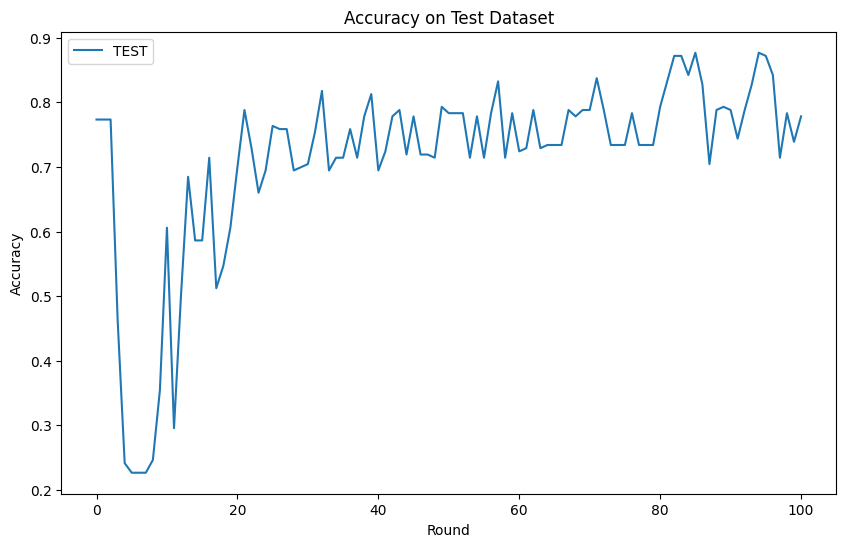

In [ ]:
import matplotlib.pyplot as plt

# Extract the accuracy metric from the history object
accuracy_test = [x[1] for x in history.metrics_centralized['accuracy TEST']]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the accuracy values
plt.plot(accuracy_test,label="TEST")

# Set the title and axis labels
plt.title("Accuracy on Test Dataset")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
# Display the plot
plt.show()


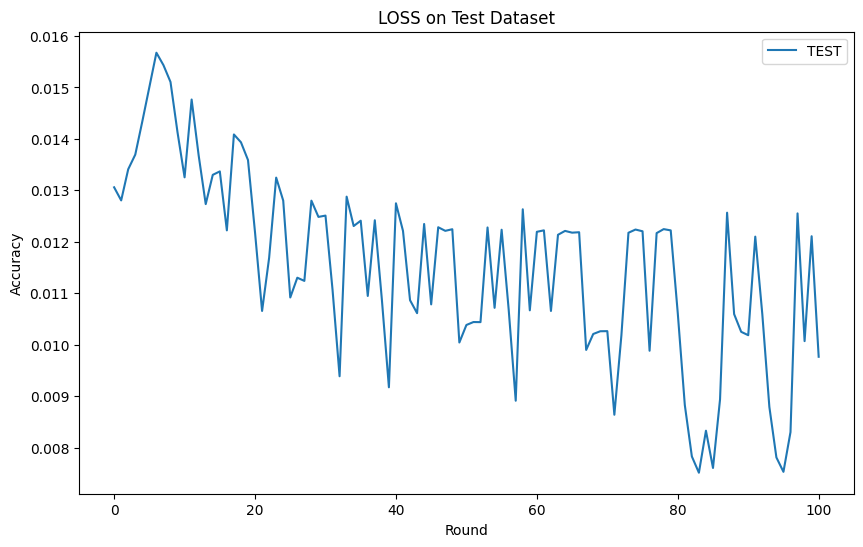

In [ ]:
import matplotlib.pyplot as plt

# Extract the accuracy metric from the history object
loss_test = [x[1] for x in history.metrics_centralized['loss TEST']]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the loss values
plt.plot(loss_test,label="TEST")

# Set the title and axis labels
plt.title("LOSS on Test Dataset")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
# Display the plot
plt.show()


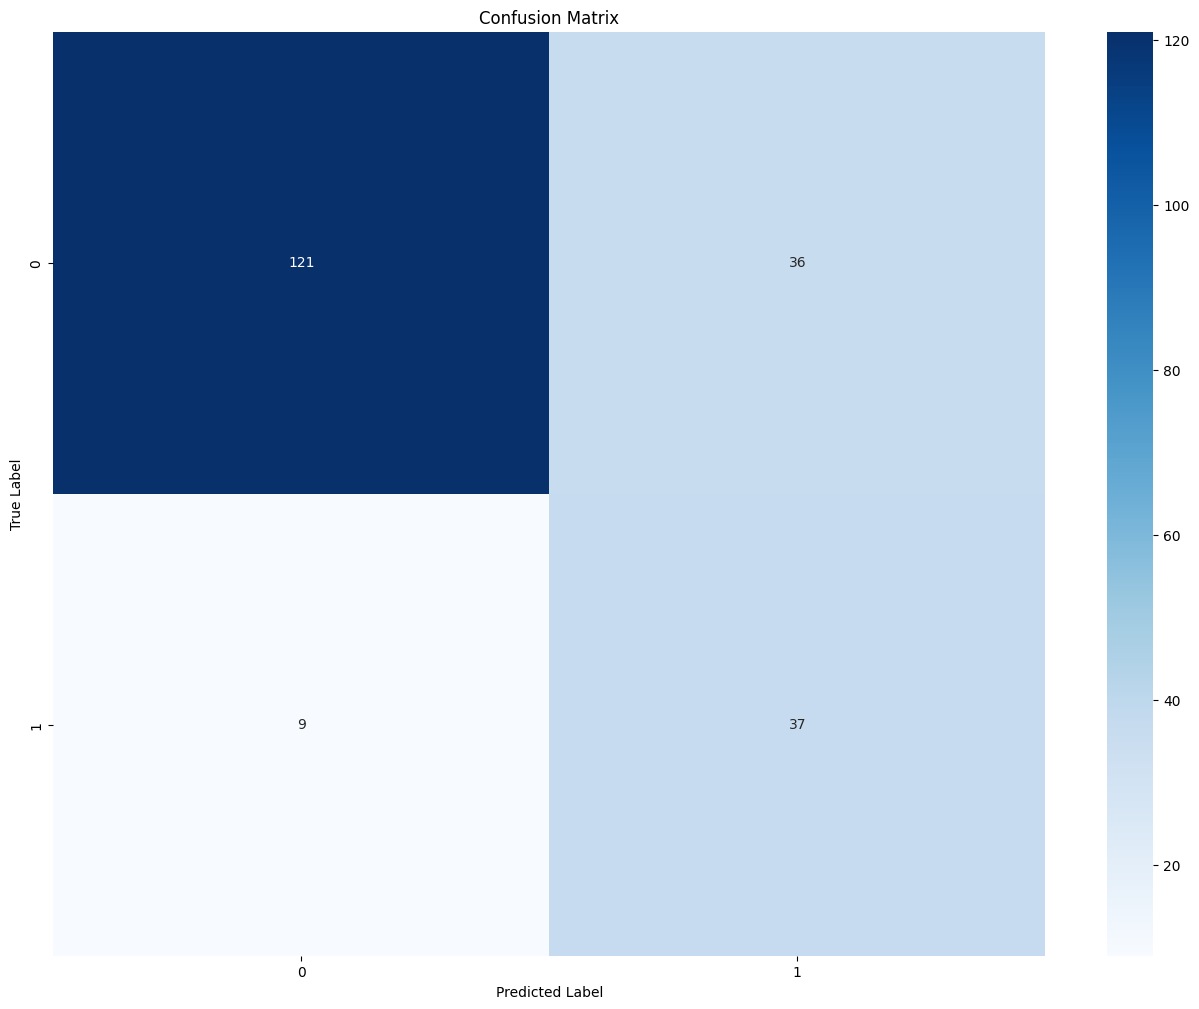

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Get the model's predictions on the public dataset

predictions = get_logits(model, testloader).cpu()

# Convert the predictions to class labels
predictions = torch.argmax(predictions, dim=1)

# Get the true labels for the public dataset
true_labels = torch.cat([batch["labels"] for batch in testloader])

# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

accuracies = []
for trainloader in trainloaders:
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in trainloader:
      inputs, labels = batch["features"].to(DEVICE), batch["labels"].to(DEVICE)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  accuracies.append(accuracy)

# Print the accuracy for each trainloader
for i, accuracy in enumerate(accuracies):
  print(f"Accuracy for trainloader {i+1}: {accuracy:.2f}%")


Accuracy for trainloader 1: 79.54%
Accuracy for trainloader 2: 76.80%
Accuracy for trainloader 3: 80.00%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


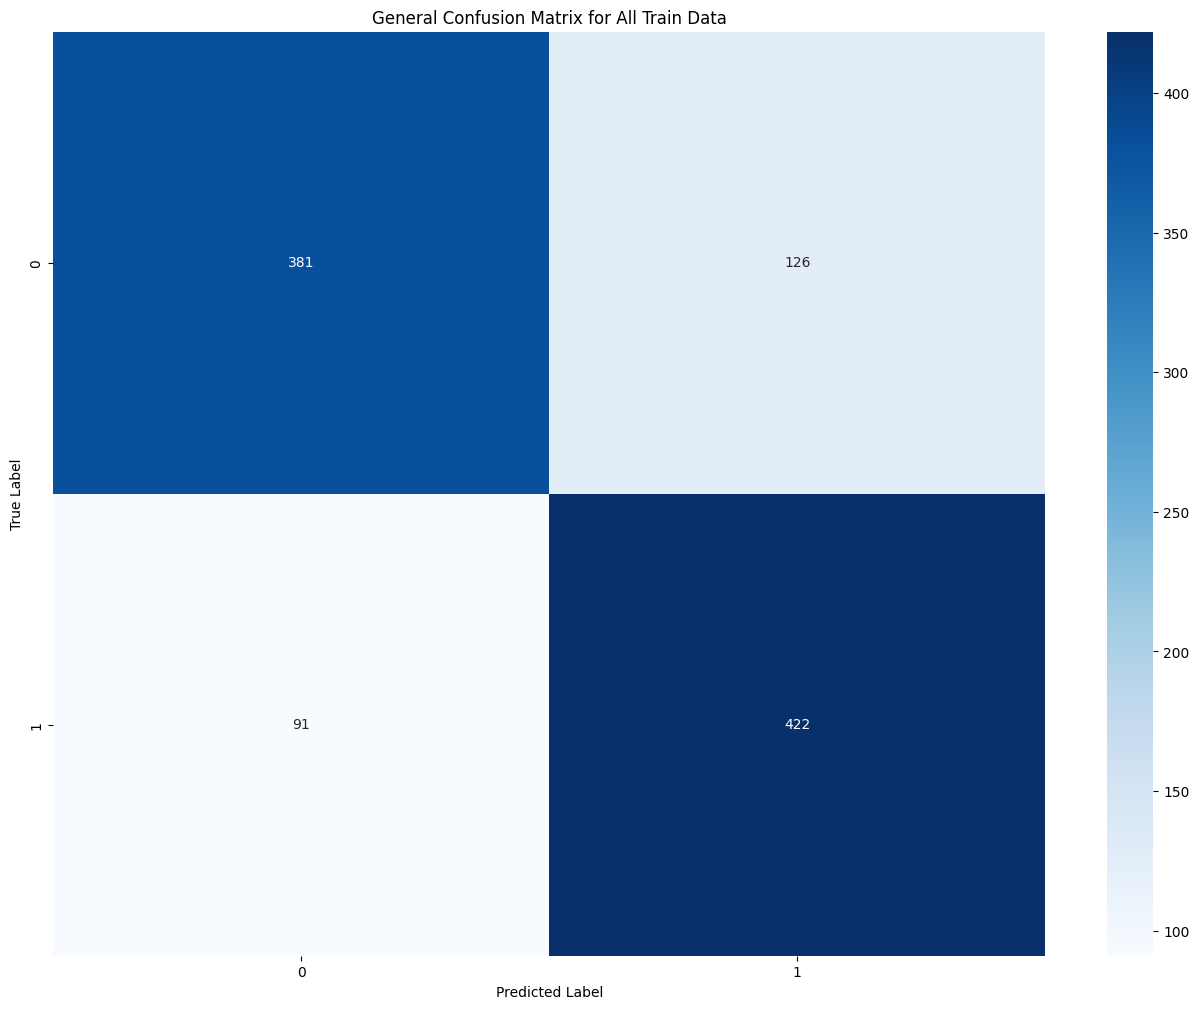

In [ ]:


# Initialize variables
all_predictions = []
all_true_labels = []

# Loop through each trainloader
for trainloader in trainloaders:
  # Get the model's predictions on the trainloader
  predictions = get_logits(model, trainloader).cpu()

  # Convert the predictions to class labels
  predictions = torch.argmax(predictions, dim=1)

  # Get the true labels for the trainloader
  true_labels = torch.cat([batch["labels"] for batch in trainloader])

  # Add the predictions and true labels to the lists
  all_predictions.extend(predictions.tolist())
  all_true_labels.extend(true_labels.tolist())

# Create the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('General Confusion Matrix for All Train Data')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
